## <h1>🎯 Contexte et Objectif du Projet</h1>

**Problème** : Sur Kickstarter, une plateforme de financement participatif, 63% des projets échouent à atteindre leur objectif financier, causant pertes de temps et ressources pour les créateurs.

**Objectif** : Développer un modèle de Machine Learning capable de prédire si un projet sera "successful" ou "failed" avec une précision supérieure à 80%.

**Données** : Analyse de 300 000+ projets Kickstarter avec 15 variables incluant la catégorie (Film, Music, Technology...), le pays de lancement, l'objectif financier, le nombre de contributeurs, la durée de campagne, la devise, et les dates de lancement.

**Méthodes** :  nettoyage des données, analyse exploratoire, feature engineering,Comparaison de 3 algorithmes (Régression Logistique, Random Forest, XGBoost)

**Livrable** : Application web Flask permettant aux créateurs d'obtenir une prédiction instantanée et des recommandations personnalisées pour optimiser leur campagne.

## ÉTAPE 1 : Importation des Bibliothèques

In [2]:
# Manipulation de données
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Date et temps
from datetime import datetime

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Évaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE

# Sauvegarde du modèle
import joblib
import pickle


## ÉTAPE 2 : Chargement des Données

In [5]:
df=pd.read_csv("ks-projects-201612.csv", encoding="cp1252", low_memory=False)

In [7]:
# taille du dataset
df.shape

(323750, 17)

In [9]:
# 5 premiers enregistrements
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              323750 non-null  int64  
 1   name            323746 non-null  object 
 2   category        323745 non-null  object 
 3   main_category   323750 non-null  object 
 4   currency        323750 non-null  object 
 5   deadline        323750 non-null  object 
 6   goal            323750 non-null  object 
 7   launched        323750 non-null  object 
 8   pledged         323750 non-null  object 
 9   state           323750 non-null  object 
 10  backers         323750 non-null  object 
 11  country         323750 non-null  object 
 12  usd pledged     319960 non-null  object 
 13  Unnamed: 13     625 non-null     object 
 14  Unnamed: 14     12 non-null      object 
 15  Unnamed: 15     4 non-null       object 
 16  Unnamed: 16     1 non-null       float64
dtypes: float64

In [13]:
#Les variables du dataset
print(df.columns.tolist())

['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ', 'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ', 'usd pledged ', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16']


## ÉTAPE 3 : NETTOYAGE DES DONNÉES

**Vérifier et Supprimer les doublons**

In [16]:
# Vérifier et Supprimer les doublons
print(f"🔍 Nombre de lignes dupliquées: {df.duplicated().sum()}")

# Supprimer les doublons
df_before = df.shape[0]
df = df.drop_duplicates()
df_after = df.shape[0]

print(f"✅ {df_before - df_after} doublons supprimés")
print(f"📊 Nouvelles dimensions: {df.shape}")

🔍 Nombre de lignes dupliquées: 0
✅ 0 doublons supprimés
📊 Nouvelles dimensions: (323750, 17)


**Supprimer les espaces au niveau des noms des colonnes**

In [20]:
df.columns = df.columns.str.strip()

**Visualiser les valeurs manquantes**

In [23]:
print("\n🔍 Valeurs manquantes par colonne:")
missing_data = pd.DataFrame({
    'Colonne': df.columns,
    'Nombre_manquant': df.isnull().sum(),
    'Pourcentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Nombre_manquant', ascending=False)

print(missing_data[missing_data['Nombre_manquant'] > 0])


🔍 Valeurs manquantes par colonne:
                 Colonne  Nombre_manquant  Pourcentage
Unnamed: 16  Unnamed: 16           323749    99.999691
Unnamed: 15  Unnamed: 15           323746    99.998764
Unnamed: 14  Unnamed: 14           323738    99.996293
Unnamed: 13  Unnamed: 13           323125    99.806950
usd pledged  usd pledged             3790     1.170656
category        category                5     0.001544
name                name                4     0.001236


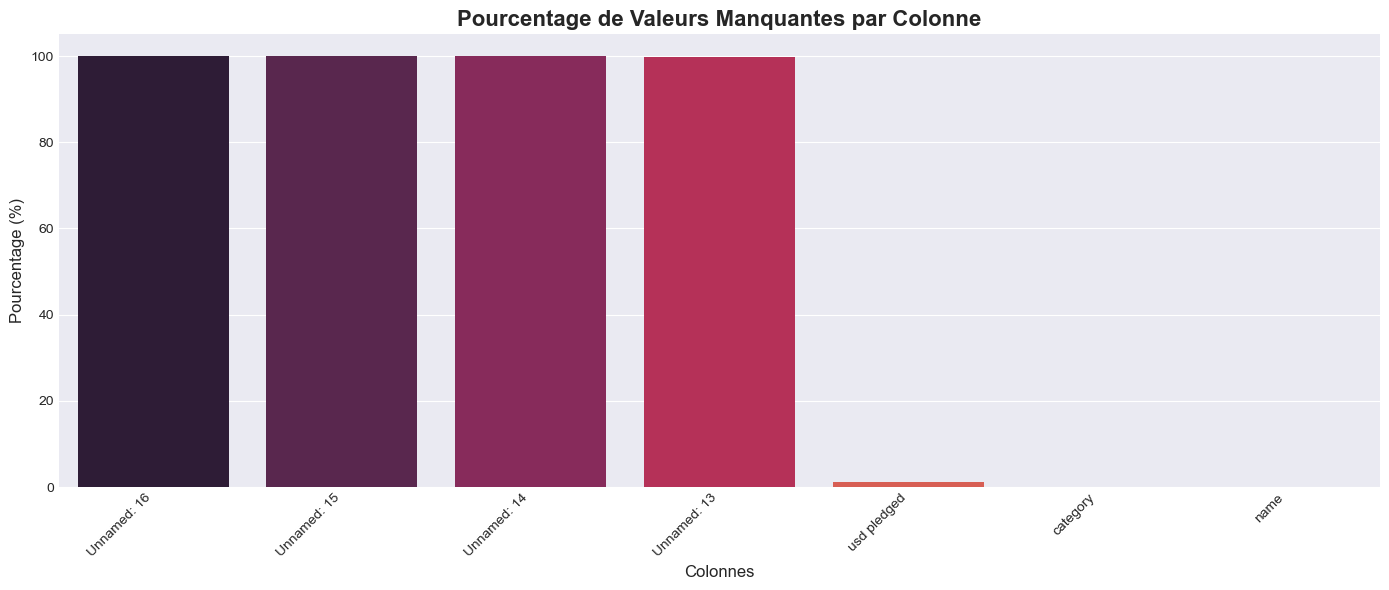

In [25]:
# Visualisation graphique des valeurs manquantes
plt.figure(figsize=(14, 6))
missing_cols = missing_data[missing_data['Nombre_manquant'] > 0]

if len(missing_cols) > 0:
    sns.barplot(data=missing_cols, x='Colonne', y='Pourcentage', palette='rocket')
    plt.title('Pourcentage de Valeurs Manquantes par Colonne', fontsize=16, fontweight='bold')
    plt.xlabel('Colonnes', fontsize=12)
    plt.ylabel('Pourcentage (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("✅ Aucune valeur manquante!")

**==>Supprimer les colonnes 'Unnamed' qui sont vides**

In [28]:
unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)
    print(f"✅ Colonnes supprimées: {unnamed_cols}")

✅ Colonnes supprimées: ['Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16']


**==>Supprimer la colonne 'name' (texte libre)**

In [31]:
if 'name' in df.columns:
    df = df.drop(columns=['name'])
    print("✅ Colonne 'name' supprimée")

✅ Colonne 'name' supprimée


**==>Supprimer 'usd pledged' car on a déjà 'usd_pledged_real'**

In [39]:
if 'usd pledged' in df.columns:
    df = df.drop(columns=['usd pledged'])
    print("✅ Colonne 'usd pledged' supprimée")

✅ Colonne 'usd pledged' supprimée


**==>Traiter les valeurs manquantes restantes**

In [42]:
print("\n🔍 Valeurs manquantes après suppression des colonnes vides:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Supprimer les lignes avec des valeurs manquantes
df = df.dropna()
print(f"\n✅ Dataset après suppression des valeurs manquantes: {df.shape}")


🔍 Valeurs manquantes après suppression des colonnes vides:
category    5
dtype: int64

✅ Dataset après suppression des valeurs manquantes: (323745, 11)


In [44]:
df.isnull().sum()

ID               0
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
pledged          0
state            0
backers          0
country          0
dtype: int64

## ÉTAPE 4 : ANALYSE EXPLORATOIRE DES DONNEES (EDA)

**==>Distribution de la variable cible 'state'**

In [47]:
# Distribution de la variable cible 'state'
print("📊 Distribution de la variable cible 'state':")
print(df['state'].value_counts())
print("\n📊 Pourcentages:")
print(df['state'].value_counts(normalize=True) * 100)

📊 Distribution de la variable cible 'state':
state
failed        168221
successful    113081
canceled       32354
live            4428
undefined       3555
               ...  
4415               1
2312               1
320                1
477                1
2634               1
Name: count, Length: 408, dtype: int64

📊 Pourcentages:
state
failed        51.960957
successful    34.929034
canceled       9.993668
live           1.367743
undefined      1.098086
                ...    
4415           0.000309
2312           0.000309
320            0.000309
477            0.000309
2634           0.000309
Name: proportion, Length: 408, dtype: float64


**==>Visualisation de la variable cible 'state'**

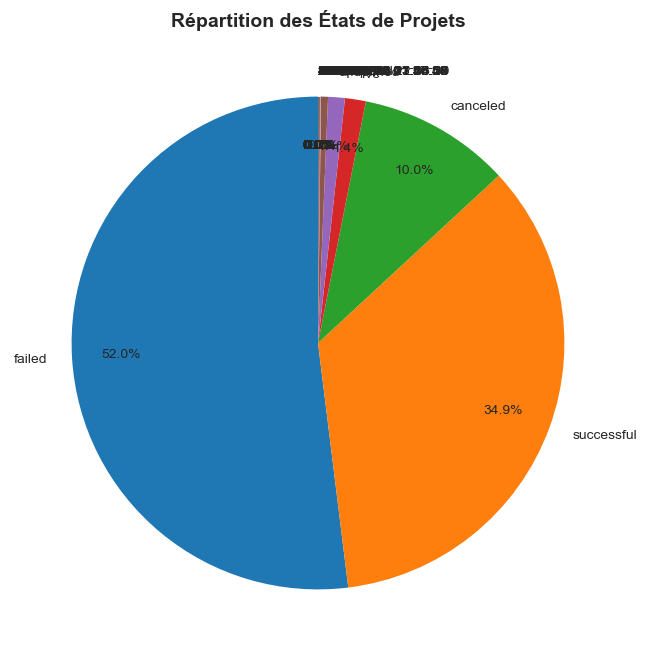

In [67]:
fig, ax = plt.subplots(figsize=(8, 8))

# Diagramme circulaire
df['state'].value_counts().plot(
    kind='pie',
    ax=ax,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.8,     # évite le chevauchement des pourcentages
    labeldistance=1.1   # évite le chevauchement des labels
)

# Titre et suppression du label Y
ax.set_title('Répartition des États de Projets', fontsize=14, fontweight='bold')
ax.set_ylabel('')

# Affichage
plt.show()


**On ne garde que 'successful' et 'failed' pour la classification binaire car les deux classes representes ~87% de notre variable cible**

In [71]:
df = df[df['state'].isin(['successful', 'failed'])]
print(f"\n✅ Dataset après filtrage: {df.shape}")
print("\n📊 Nouvelle distribution:")
print(df['state'].value_counts())


✅ Dataset après filtrage: (281302, 11)

📊 Nouvelle distribution:
state
failed        168221
successful    113081
Name: count, dtype: int64


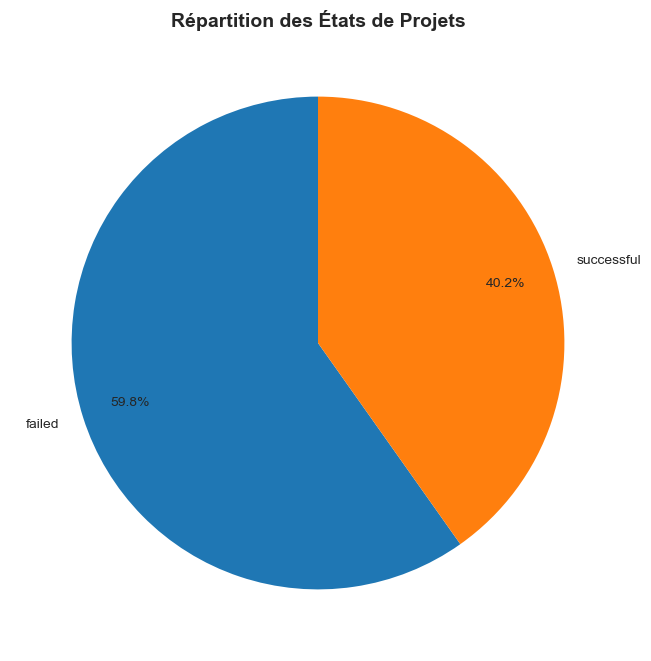

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))

# Diagramme circulaire
df['state'].value_counts().plot(
    kind='pie',
    ax=ax,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.8,     # évite le chevauchement des pourcentages
    labeldistance=1.1   # évite le chevauchement des labels
)

# Titre et suppression du label Y
ax.set_title('Répartition des États de Projets', fontsize=14, fontweight='bold')
ax.set_ylabel('')

# Affichage
plt.show()


**==>Distribution des catégories principales**

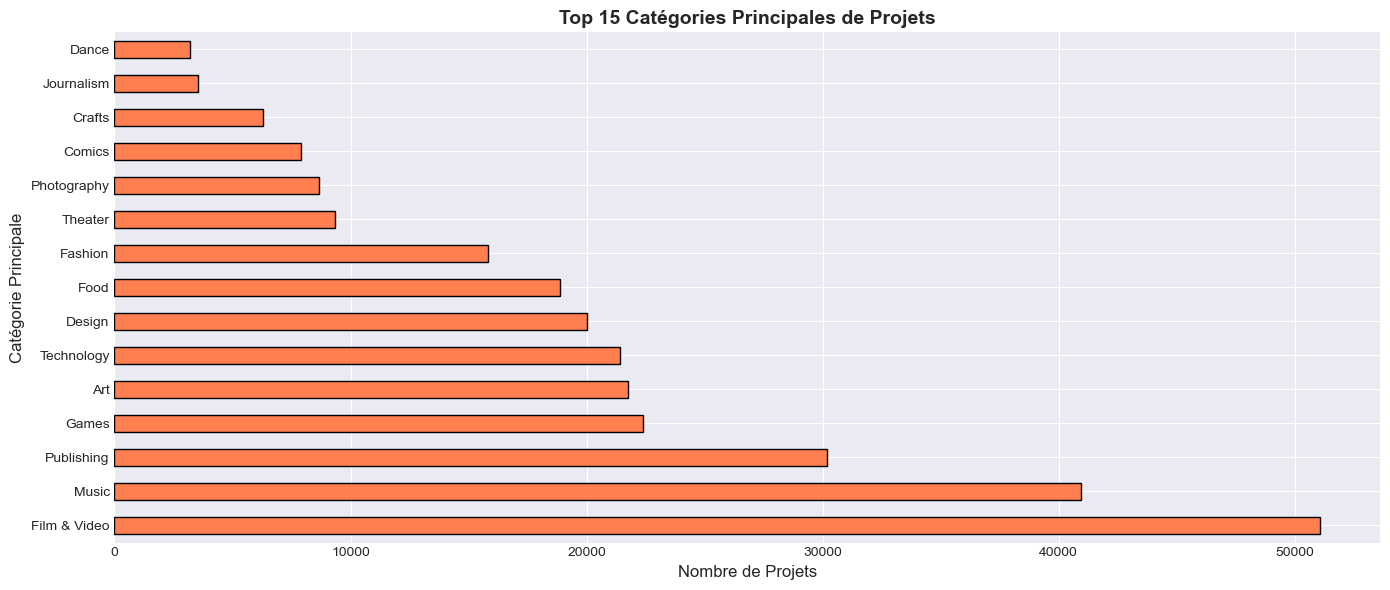

In [76]:
plt.figure(figsize=(14, 6))
df['main_category'].value_counts().head(15).plot(kind='barh', color='coral', edgecolor='black')
plt.title('Top 15 Catégories Principales de Projets', fontsize=14, fontweight='bold')
plt.xlabel('Nombre de Projets', fontsize=12)
plt.ylabel('Catégorie Principale', fontsize=12)
plt.tight_layout()
plt.show()

**==>Distribution des pays**

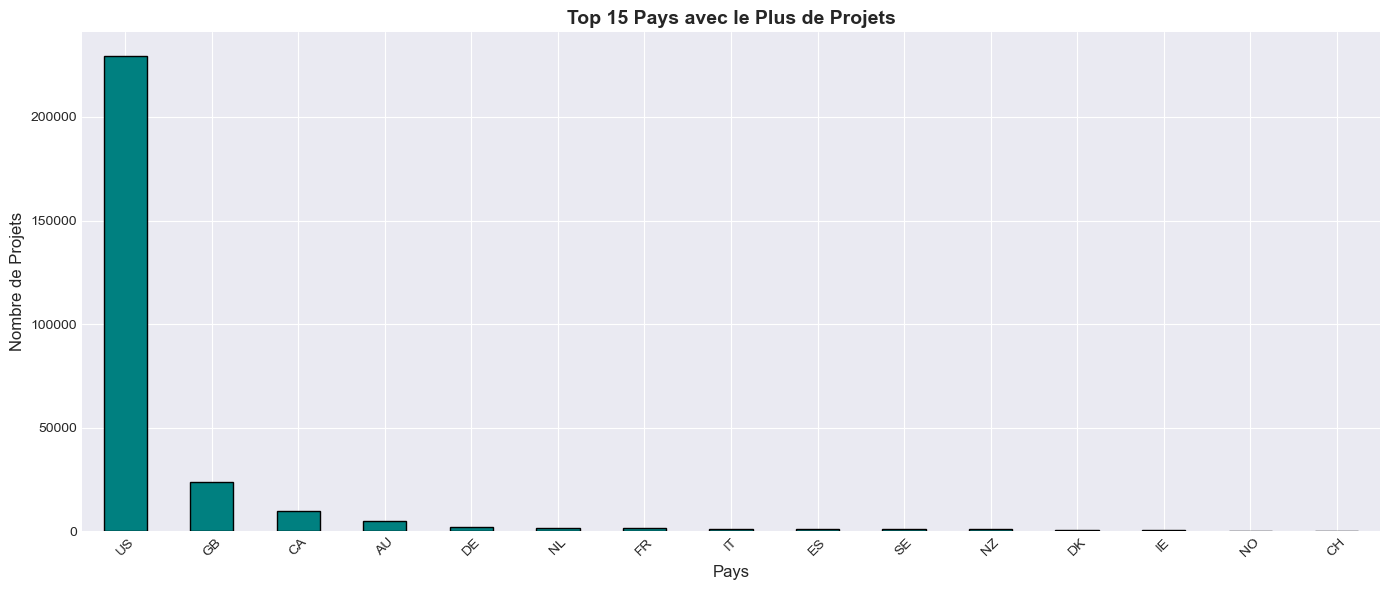

In [79]:
plt.figure(figsize=(14, 6))
df['country'].value_counts().head(15).plot(kind='bar', color='teal', edgecolor='black')
plt.title('Top 15 Pays avec le Plus de Projets', fontsize=14, fontweight='bold')
plt.xlabel('Pays', fontsize=12)
plt.ylabel('Nombre de Projets', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Taux de succès par catégorie principale**

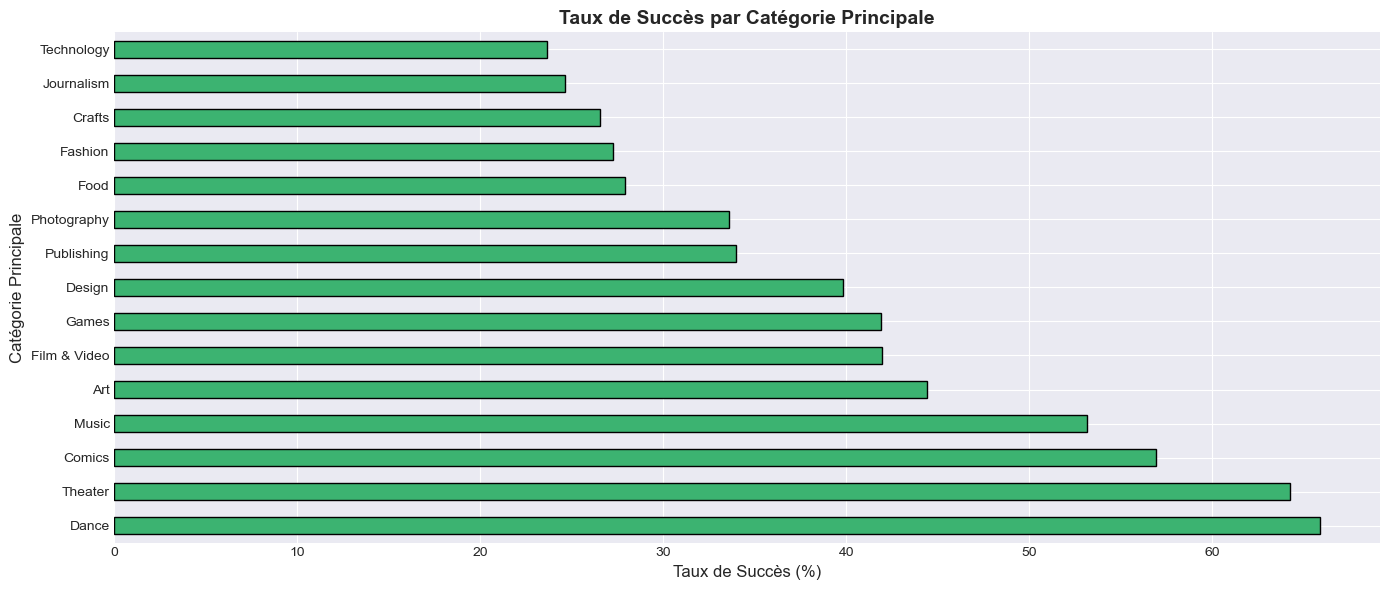

In [82]:
success_by_category = df.groupby('main_category')['state'].apply(
    lambda x: (x == 'successful').sum() / len(x) * 100
).sort_values(ascending=False)

plt.figure(figsize=(14, 6))
success_by_category.plot(kind='barh', color='mediumseagreen', edgecolor='black')
plt.title('Taux de Succès par Catégorie Principale', fontsize=14, fontweight='bold')
plt.xlabel('Taux de Succès (%)', fontsize=12)
plt.ylabel('Catégorie Principale', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
**Conversion des variables goals et backers**

In [87]:
df['backers'] = pd.to_numeric(df['backers'])
df['goal'] = pd.to_numeric(df['goal'])

**=>Relation entre Backers et State**

<Figure size 1200x600 with 0 Axes>

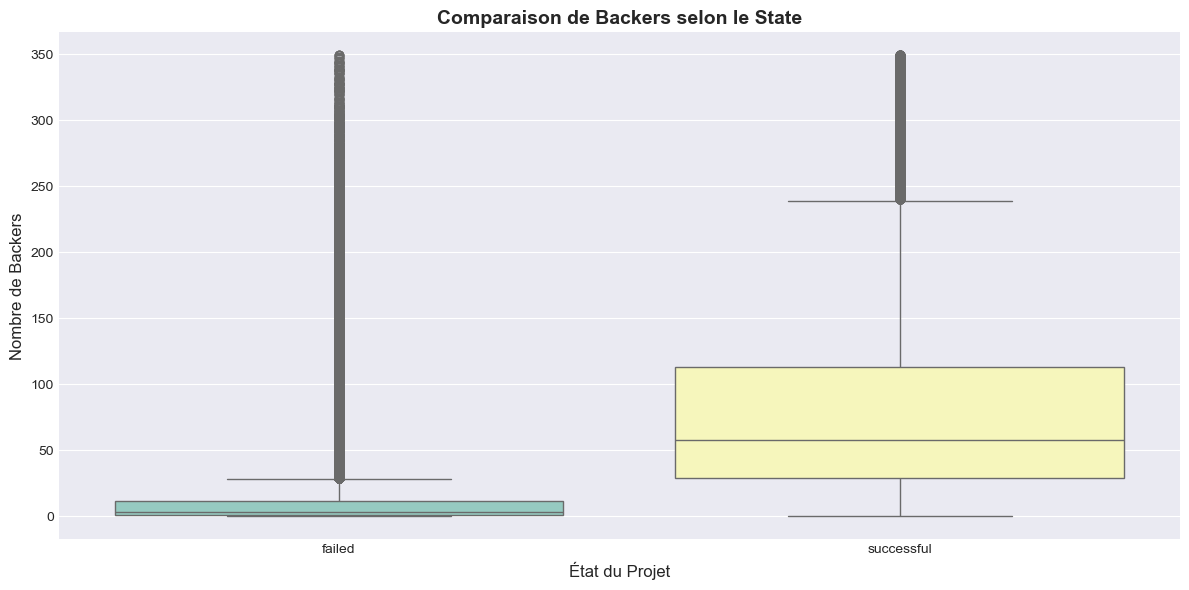

In [89]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['backers'] < df['backers'].quantile(0.95)], x='state', y='backers', palette='Set3')
plt.title('Comparaison de Backers selon le State', fontsize=14, fontweight='bold')
plt.xlabel('État du Projet', fontsize=12)
plt.ylabel('Nombre de Backers', fontsize=12)
plt.tight_layout()
plt.show()

**==>Relation entre Goal et State**

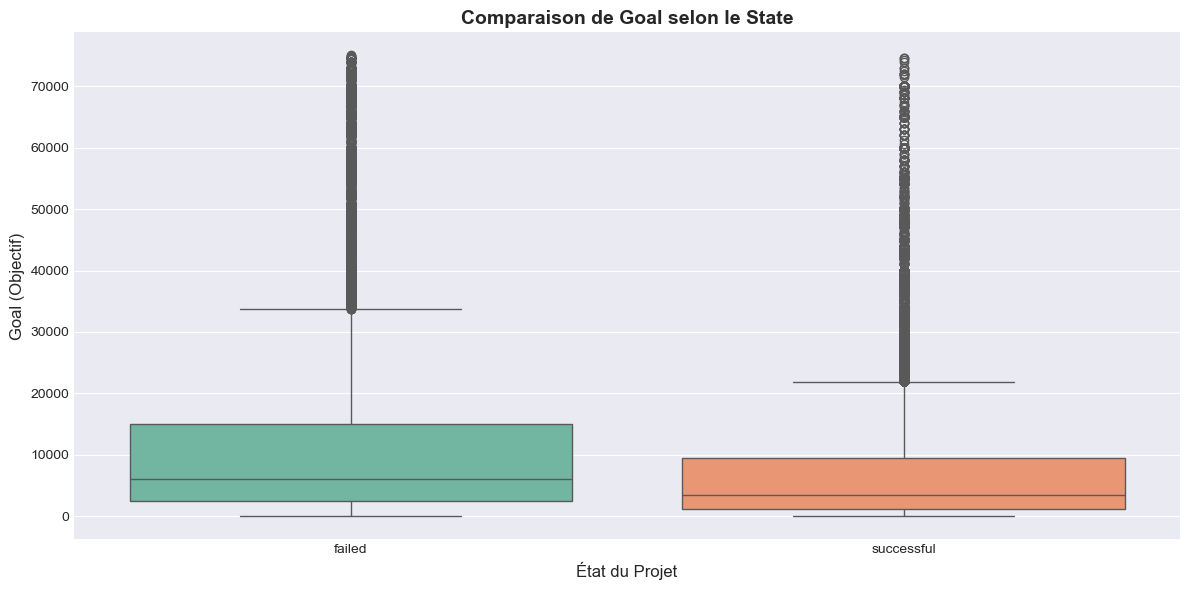

In [92]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['goal'] < df['goal'].quantile(0.95)], x='state', y='goal', palette='Set2')
plt.title('Comparaison de Goal selon le State', fontsize=14, fontweight='bold')
plt.xlabel('État du Projet', fontsize=12)
plt.ylabel('Goal (Objectif)', fontsize=12)
plt.tight_layout()
plt.show()

**==>Comparaison des moyennes par state**

In [98]:
df['pledged'] = pd.to_numeric(df['pledged'])
print("\n📊 Comparaison des moyennes par state:")
comparison = df.groupby('state')[['goal', 'pledged', 'backers']].mean()
print(comparison)


📊 Comparaison des moyennes par state:
                    goal       pledged     backers
state                                             
failed      63484.142409   1368.892928   16.771230
successful   9624.572525  21489.555282  253.624322


**==>Matrice de corrélation**

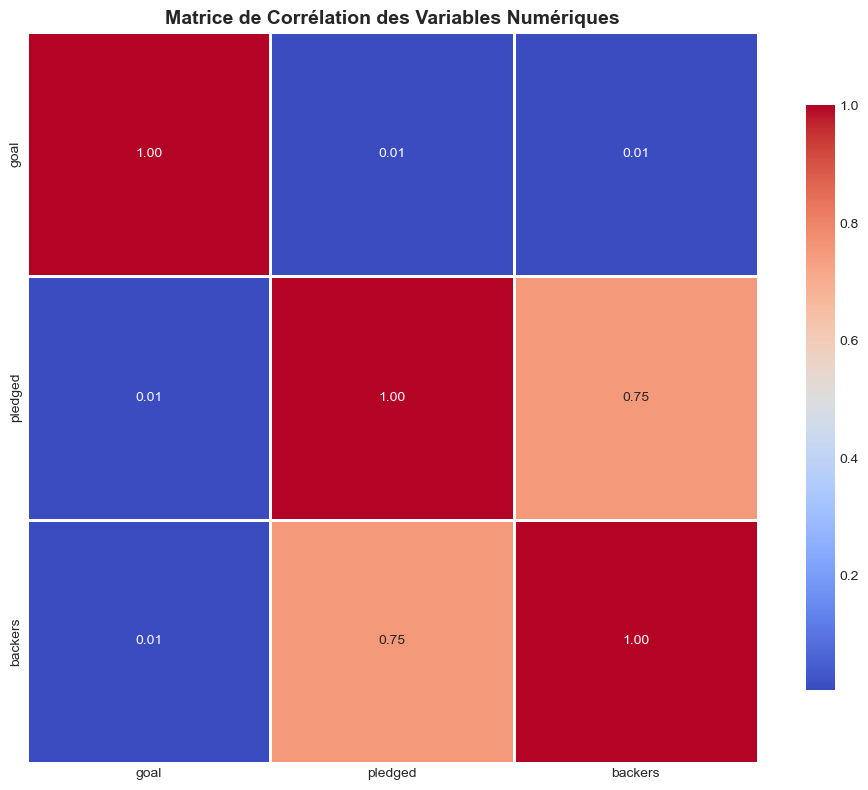

In [103]:
numeric_features = ['goal', 'pledged', 'backers']
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
            linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Variables Numériques', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

une forte correlation entre backers(Nombre de contributeurs ayant soutenu financièrement le projet) et pledged(Montant total effectivement collecté par la campagne)

## ÉTAPE 5 : PRÉPARATION DES DONNÉES (PREPROCESSING)

**==>Créer une copie pour le preprocessing**

In [110]:
df_model = df.copy()

print(f"📊 Dataset pour la modélisation: {df_model.shape}")

📊 Dataset pour la modélisation: (281302, 12)


In [112]:
#Les variables du dataset
print(df_model.columns.tolist())

['ID', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'pledgel']


In [116]:
df_model.sample(5)

,ID,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,pledgel
82051,148759962,Performances,Dance,USD,2015-11-20 09:00:00,3200.0,2015-10-25 22:36:25,3295.0,successful,59,US,3295.0
225044,407204174,Apparel,Fashion,USD,2015-07-23 20:59:04,350.0,2015-07-09 20:59:04,30.0,failed,1,US,30.0
311731,927705227,Video Games,Games,USD,2013-02-03 12:14:49,10000.0,2013-01-04 12:14:49,546.0,failed,39,US,546.0
294695,825442635,Live Games,Games,USD,2016-11-04 14:13:33,4000.0,2016-10-05 15:13:33,4305.0,successful,69,US,4305.0
96167,1571258513,Theater,Theater,USD,2014-04-12 03:12:18,6000.0,2014-03-13 02:12:18,1291.0,failed,7,US,1291.0


In [118]:
# suppression de pledgel qui est une duplication de pledged
df_model = df_model.drop(columns=['pledgel'])

## Feature Engeenering

**==>Convertir les dates en datetime**

In [121]:
df_model['deadline'] = pd.to_datetime(df_model['deadline'])
df_model['launched'] = pd.to_datetime(df_model['launched'])

# Créer de nouvelles features temporelles
df_model['campaign_days'] = (df_model['deadline'] - df_model['launched']).dt.days
df_model['launch_year'] = df_model['launched'].dt.year
df_model['launch_month'] = df_model['launched'].dt.month
df_model['launch_day'] = df_model['launched'].dt.day
df_model['launch_weekday'] = df_model['launched'].dt.dayofweek

print("✅ Features temporelles créées!")
print(df_model[['campaign_days', 'launch_year', 'launch_month', 'launch_day', 'launch_weekday']].head())

✅ Features temporelles créées!
   campaign_days  launch_year  launch_month  launch_day  launch_weekday
0             58         2015             8          11               1
1             45         2013             1          12               5
2             30         2012             3          17               5
4             35         2016             2          26               4
5             20         2014            12           1               0


In [123]:
# Créer des features supplémentaires
df_model['goal_category'] = pd.cut(df_model['goal'], 
                                     bins=[0, 1000, 5000, 10000, 50000, np.inf],
                                     labels=['très_faible', 'faible', 'moyen', 'élevé', 'très_élevé'])

print("✅ Feature 'goal_category' créée!")

✅ Feature 'goal_category' créée!


**==>Supprimer les colonnes inutiles**

In [128]:
#Les variables du dataset
print(df_model.columns.tolist())

['ID', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'campaign_days', 'launch_year', 'launch_month', 'launch_day', 'launch_weekday', 'goal_category']


In [130]:
cols_to_drop = ['deadline', 'launched', 'ID', 'pledged', 'category']
cols_to_drop = [col for col in cols_to_drop if col in df_model.columns]

df_model = df_model.drop(columns=cols_to_drop)
print(f"✅ Colonnes supprimées: {cols_to_drop}")
print(f"\n📊 Nouvelles dimensions: {df_model.shape}")

✅ Colonnes supprimées: ['deadline', 'launched', 'ID', 'pledged', 'category']

📊 Nouvelles dimensions: (281302, 12)


**==>Identification et l'encodage  des colonnes catégorielles**

In [133]:
cat_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.remove('state')  # On enlève la variable cible

print(f"📋 Colonnes catégorielles à encoder: {cat_cols}")

📋 Colonnes catégorielles à encoder: ['main_category', 'currency', 'country', 'goal_category']


In [135]:
# Label Encoding pour les colonnes catégorielles
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"✅ {col} encodée")

print("\n✅ Toutes les variables catégorielles ont été encodées!")

✅ main_category encodée
✅ currency encodée
✅ country encodée
✅ goal_category encodée

✅ Toutes les variables catégorielles ont été encodées!


In [137]:
# Encoder la variable cible
le_state = LabelEncoder()
df_model['state'] = le_state.fit_transform(df_model['state'])

print("📊 Encodage de la variable cible:")
print(f"failed = {le_state.transform(['failed'])[0]}")
print(f"successful = {le_state.transform(['successful'])[0]}")

📊 Encodage de la variable cible:
failed = 0
successful = 1


**==>Séparer X (features) et y (target)**

In [140]:
X = df_model.drop('state', axis=1)
y = df_model['state']

print(f"✅ Features (X): {X.shape}")
print(f"✅ Target (y): {y.shape}")
print(f"\n📊 Distribution de y:")
print(y.value_counts())

✅ Features (X): (281302, 11)
✅ Target (y): (281302,)

📊 Distribution de y:
state
0    168221
1    113081
Name: count, dtype: int64


**==>Split des données (80% train, 20% test)**

In [143]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ X_train: {X_train.shape}")
print(f"✅ X_test: {X_test.shape}")
print(f"✅ y_train: {y_train.shape}")
print(f"✅ y_test: {y_test.shape}")

print(f"\n📊 Distribution de y_train:")
print(y_train.value_counts())
print(f"\n📊 Distribution de y_test:")
print(y_test.value_counts())

✅ X_train: (225041, 11)
✅ X_test: (56261, 11)
✅ y_train: (225041,)
✅ y_test: (56261,)

📊 Distribution de y_train:
state
0    134576
1     90465
Name: count, dtype: int64

📊 Distribution de y_test:
state
0    33645
1    22616
Name: count, dtype: int64


**==>Standardisation des features numériques**

In [146]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Données normalisées avec StandardScaler!")

✅ Données normalisées avec StandardScaler!


**==>Equilibrer les donnees d'entrainement avec SMOTE**

In [153]:
# Vérifier le déséquilibre
print("📊 Distribution avant SMOTE:")
print(f"Classe 0: {(y_train == 0).sum()}")
print(f"Classe 1: {(y_train == 1).sum()}")

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\n📊 Distribution après SMOTE:")
print(f"Classe 0: {(y_train_balanced == 0).sum()}")
print(f"Classe 1: {(y_train_balanced == 1).sum()}")

print(f"\n✅ Nouvelles dimensions après SMOTE:")
print(f"X_train_balanced: {X_train_balanced.shape}")
print(f"y_train_balanced: {y_train_balanced.shape}")

📊 Distribution avant SMOTE:
Classe 0: 134576
Classe 1: 90465

📊 Distribution après SMOTE:
Classe 0: 134576
Classe 1: 134576

✅ Nouvelles dimensions après SMOTE:
X_train_balanced: (269152, 11)
y_train_balanced: (269152,)


## ÉTAPE 6 : MODÉLISATION

**6.1 Régression Logistique**

In [158]:
print("🤖 Entraînement de la Régression Logistique...")

# Créer et entraîner le modèle
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_balanced, y_train_balanced)

# Prédictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Évaluation
print("\n📊 Résultats de la Régression Logistique:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

print("\n📋 Rapport de Classification:")
print(classification_report(y_test, y_pred_lr, target_names=['failed', 'successful']))

🤖 Entraînement de la Régression Logistique...

📊 Résultats de la Régression Logistique:
Accuracy: 0.8941
Precision: 0.8932
Recall: 0.8367
F1-Score: 0.8640
ROC-AUC: 0.9530

📋 Rapport de Classification:
              precision    recall  f1-score   support

      failed       0.89      0.93      0.91     33645
  successful       0.89      0.84      0.86     22616

    accuracy                           0.89     56261
   macro avg       0.89      0.88      0.89     56261
weighted avg       0.89      0.89      0.89     56261



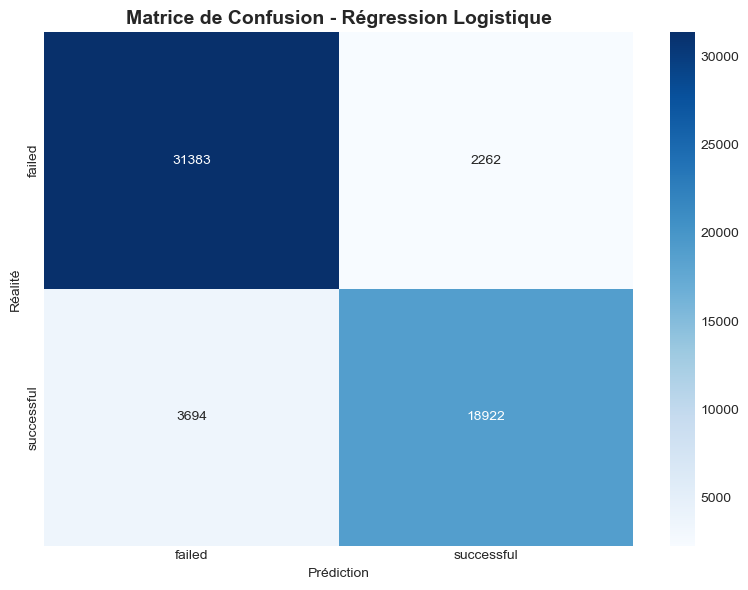

In [160]:
# Matrice de confusion
plt.figure(figsize=(8, 6))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['failed', 'successful'], 
            yticklabels=['failed', 'successful'])
plt.title('Matrice de Confusion - Régression Logistique', fontsize=14, fontweight='bold')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.tight_layout()
plt.show()

**6.2 Random Forest**

In [162]:
print("🌲 Entraînement de Random Forest...")

# Créer et entraîner le modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)

# Prédictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Évaluation
print("\n📊 Résultats de Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\n📋 Rapport de Classification:")
print(classification_report(y_test, y_pred_rf, target_names=['failed', 'successful']))

🌲 Entraînement de Random Forest...

📊 Résultats de Random Forest:
Accuracy: 0.9293
Precision: 0.8978
Recall: 0.9302
F1-Score: 0.9137
ROC-AUC: 0.9801

📋 Rapport de Classification:
              precision    recall  f1-score   support

      failed       0.95      0.93      0.94     33645
  successful       0.90      0.93      0.91     22616

    accuracy                           0.93     56261
   macro avg       0.92      0.93      0.93     56261
weighted avg       0.93      0.93      0.93     56261



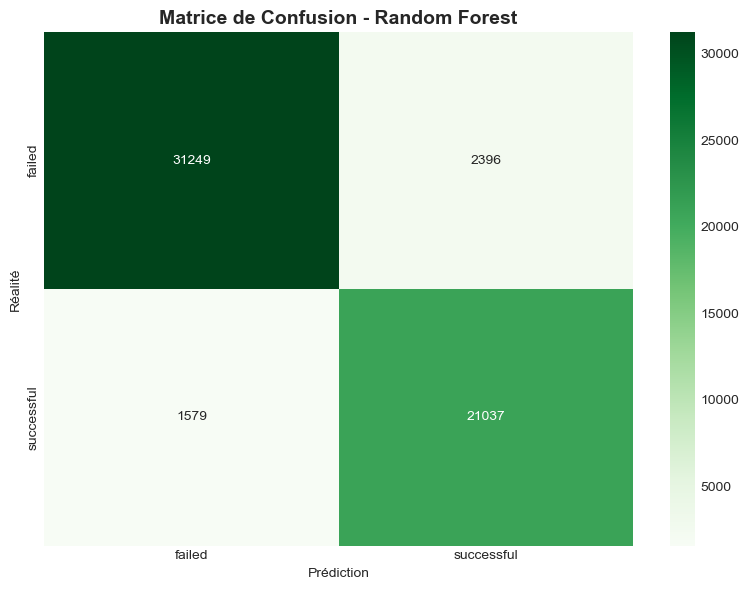

In [164]:
# Matrice de confusion
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['failed', 'successful'], 
            yticklabels=['failed', 'successful'])
plt.title('Matrice de Confusion - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.tight_layout()
plt.show()

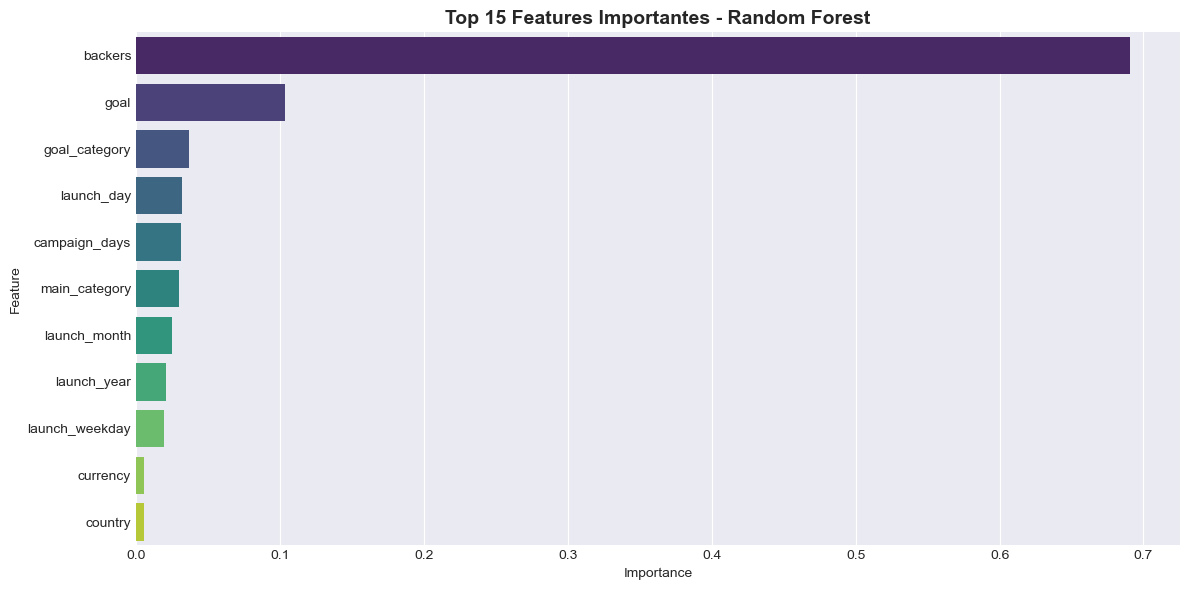

In [166]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Features Importantes - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**6.3 XGBoost**

In [169]:
print("⚡ Entraînement de XGBoost...")

# Créer et entraîner le modèle
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, 
                          eval_metric='logloss', n_jobs=-1)
xgb_model.fit(X_train_balanced, y_train_balanced)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Évaluation
print("\n📊 Résultats de XGBoost:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

print("\n📋 Rapport de Classification:")
print(classification_report(y_test, y_pred_xgb, target_names=['failed', 'successful']))

⚡ Entraînement de XGBoost...

📊 Résultats de XGBoost:
Accuracy: 0.9346
Precision: 0.9074
Recall: 0.9324
F1-Score: 0.9197
ROC-AUC: 0.9836

📋 Rapport de Classification:
              precision    recall  f1-score   support

      failed       0.95      0.94      0.94     33645
  successful       0.91      0.93      0.92     22616

    accuracy                           0.93     56261
   macro avg       0.93      0.93      0.93     56261
weighted avg       0.94      0.93      0.93     56261



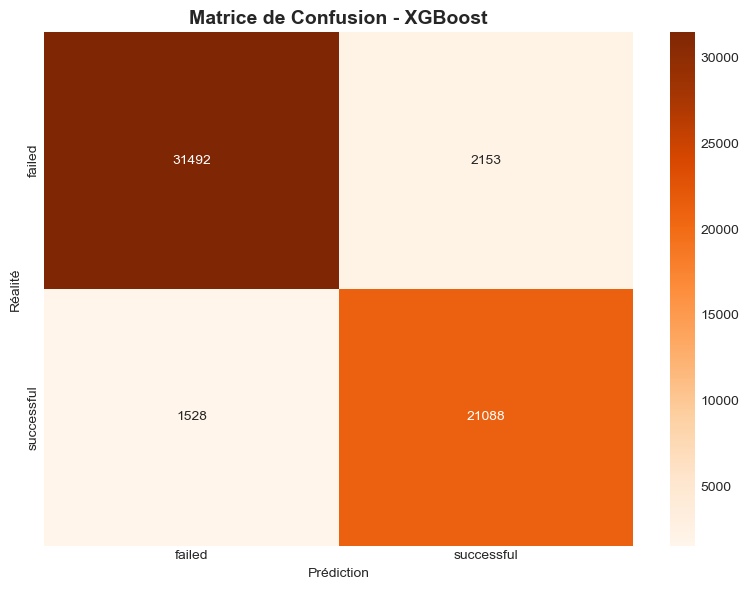

In [171]:
# Matrice de confusion
plt.figure(figsize=(8, 6))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['failed', 'successful'], 
            yticklabels=['failed', 'successful'])
plt.title('Matrice de Confusion - XGBoost', fontsize=14, fontweight='bold')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.tight_layout()
plt.show()

## ÉTAPE 7 : COMPARAISON DES MODÈLES

In [174]:
# Créer un DataFrame pour comparer les modèles
results = pd.DataFrame({
    'Modèle': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb)
    ]
})

print("📊 Comparaison des Modèles:")
print(results)

📊 Comparaison des Modèles:
                Modèle  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.894136   0.893221  0.836664  0.864018  0.953018
1        Random Forest  0.929347   0.897751  0.930182  0.913679  0.980093
2              XGBoost  0.934573   0.907362  0.932437  0.919729  0.983563


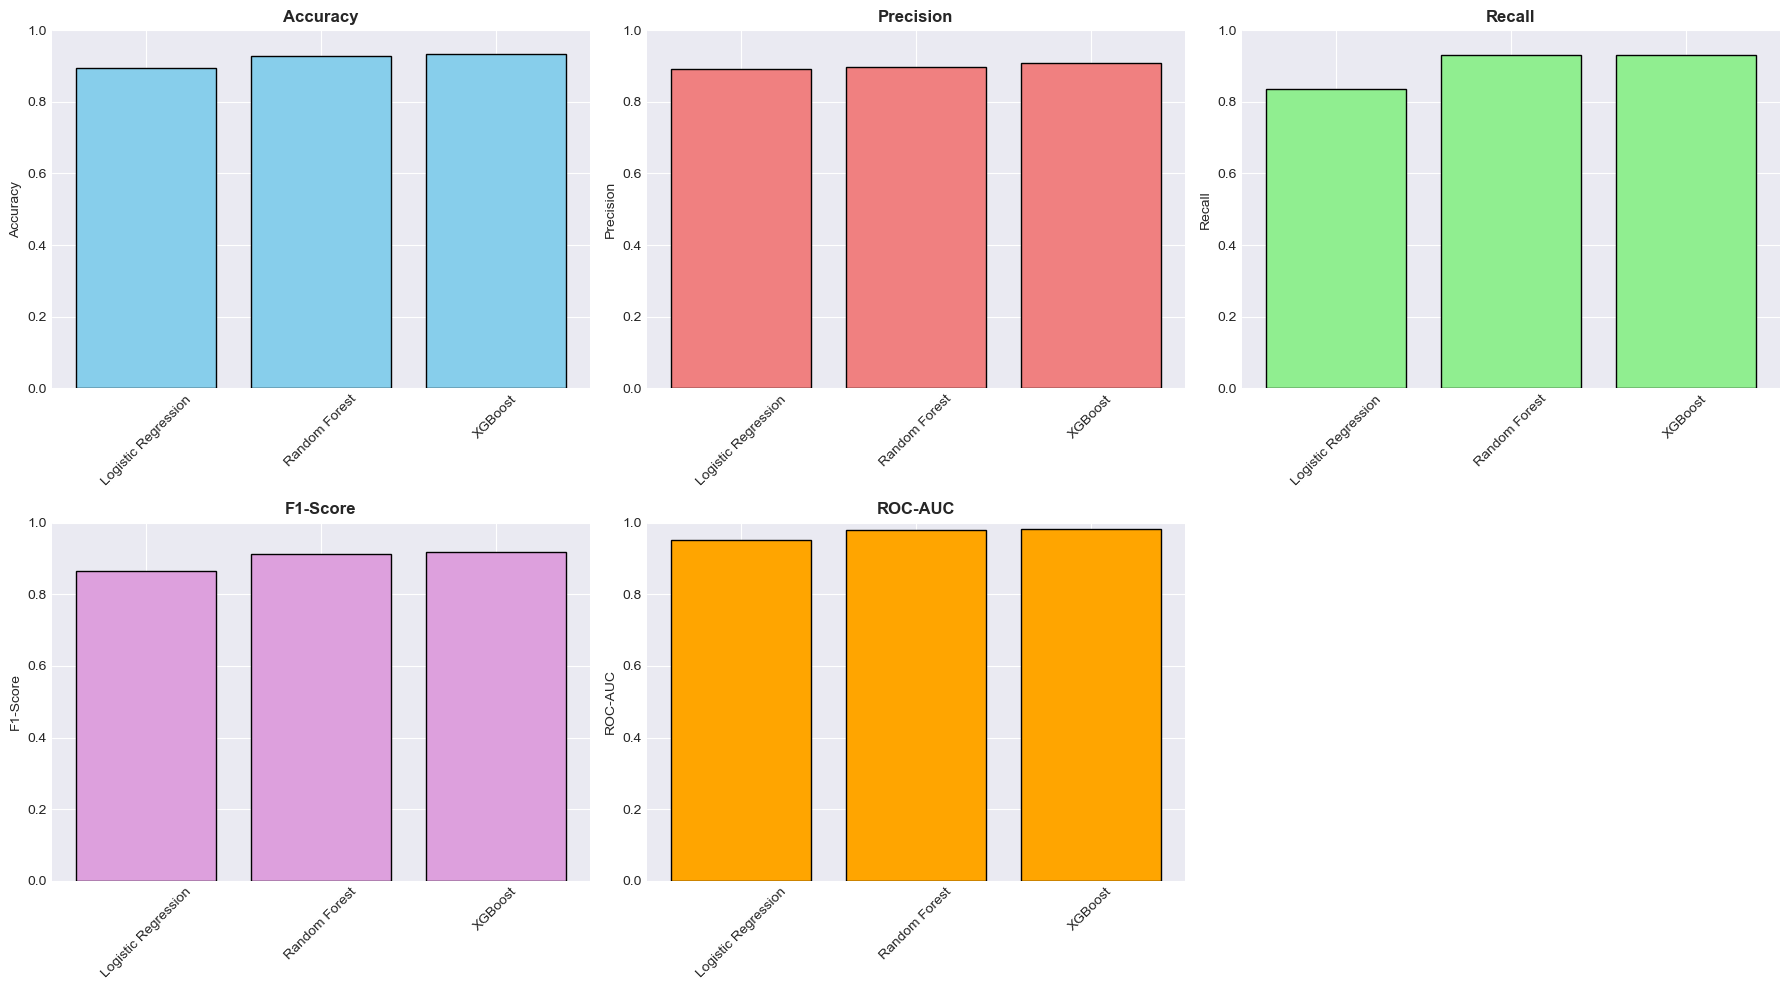

In [176]:
# Visualisation de la comparaison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum', 'orange']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    axes[row, col].bar(results['Modèle'], results[metric], color=colors[idx], edgecolor='black')
    axes[row, col].set_title(f'{metric}', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(metric)
    axes[row, col].set_ylim([0, 1])
    axes[row, col].tick_params(axis='x', rotation=45)

# Supprimer le dernier subplot vide
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

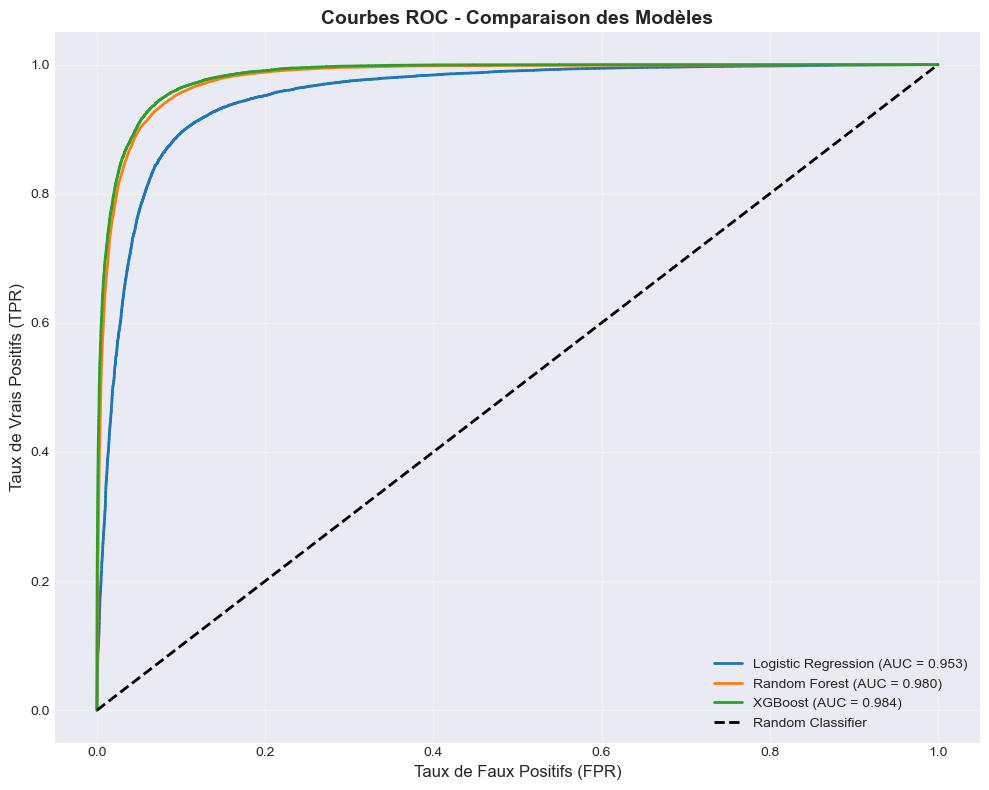

In [178]:
# Courbes ROC pour tous les modèles
plt.figure(figsize=(10, 8))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbes ROC - Comparaison des Modèles', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ÉTAPE 8 : SÉLECTION ET SAUVEGARDE DU MEILLEUR MODÈLE

**==>Identifier le meilleur modèle basé sur ROC-AUC**

In [181]:
best_model_name = results.loc[results['ROC-AUC'].idxmax(), 'Modèle']
best_roc_auc = results['ROC-AUC'].max()

print(f"🏆 Meilleur Modèle: {best_model_name}")
print(f"🏆 ROC-AUC Score: {best_roc_auc:.4f}")

# Sélectionner le meilleur modèle
models_dict = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

best_model = models_dict[best_model_name]

🏆 Meilleur Modèle: XGBoost
🏆 ROC-AUC Score: 0.9836


**==>Sauvegarder le meilleur modèle**

In [187]:
joblib.dump(best_model, 'best_kickstarter_model.pkl')
print(f"✅ Modèle sauvegardé: best_kickstarter_model.pkl")

# Sauvegarder aussi le scaler et les label encoders
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(le_state, 'label_encoder_state.pkl')

print("✅ Scaler et Label Encoders sauvegardés!")

✅ Modèle sauvegardé: best_kickstarter_model.pkl
✅ Scaler et Label Encoders sauvegardés!


In [189]:
# Sauvegarder les noms des features
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print(f"✅ Feature names sauvegardés: {len(feature_names)} features")

✅ Feature names sauvegardés: 11 features


**==>Créer un dictionnaire avec toutes les informations du modèle**

In [192]:
model_info = {
    'model_name': best_model_name,
    'roc_auc': best_roc_auc,
    'accuracy': results.loc[results['Modèle'] == best_model_name, 'Accuracy'].values[0],
    'precision': results.loc[results['Modèle'] == best_model_name, 'Precision'].values[0],
    'recall': results.loc[results['Modèle'] == best_model_name, 'Recall'].values[0],
    'f1_score': results.loc[results['Modèle'] == best_model_name, 'F1-Score'].values[0],
    'feature_names': feature_names,
    'date_trained': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

joblib.dump(model_info, 'model_info.pkl')
print("\n✅ Informations du modèle sauvegardées!")
print(f"\n📊 Résumé du modèle:")
for key, value in model_info.items():
    if key != 'feature_names':
        print(f"  {key}: {value}")


✅ Informations du modèle sauvegardées!

📊 Résumé du modèle:
  model_name: XGBoost
  roc_auc: 0.9835625828903011
  accuracy: 0.93457279465349
  precision: 0.9073619895873671
  recall: 0.9324372125928546
  f1_score: 0.9197287218963299
  date_trained: 2026-01-30 10:20:22


In [194]:
print("="*60)
print("🎉 PROJET MACHINE LEARNING TERMINÉ AVEC SUCCÈS!")
print("="*60)
print("\n📦 Fichiers sauvegardés:")
print("  ✅ best_kickstarter_model.pkl")
print("  ✅ scaler.pkl")
print("  ✅ label_encoders.pkl")
print("  ✅ label_encoder_state.pkl")
print("  ✅ feature_names.pkl")
print("  ✅ model_info.pkl")
print("\n🚀 Prochaine étape: Créer l'application Flask!")
print("="*60)

🎉 PROJET MACHINE LEARNING TERMINÉ AVEC SUCCÈS!

📦 Fichiers sauvegardés:
  ✅ best_kickstarter_model.pkl
  ✅ scaler.pkl
  ✅ label_encoders.pkl
  ✅ label_encoder_state.pkl
  ✅ feature_names.pkl
  ✅ model_info.pkl

🚀 Prochaine étape: Créer l'application Flask!
